In [1]:
import rebound
import numpy as np
from numpy.random import random, seed
import matplotlib.pyplot as plt
%matplotlib inline

In [285]:
def sample():
    e1 = random()
    e2 = random()*(1-e1)
    return e1, e2

In [290]:
emax=1
es = [np.sqrt(random()*emax**2) for i in range(10000)]

(array([ 116.,  302.,  518.,  666.,  923., 1129., 1269., 1473., 1745.,
        1859.]),
 array([0.00526289, 0.10473287, 0.20420285, 0.30367283, 0.40314281,
        0.50261279, 0.60208277, 0.70155275, 0.80102273, 0.90049271,
        0.99996269]),
 <a list of 10 Patch objects>)

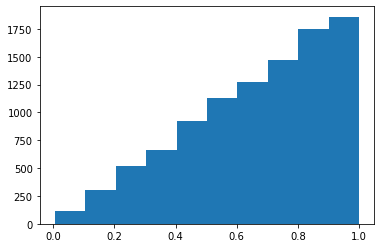

In [291]:
fig, ax = plt.subplots()
ax.hist(es)

In [5]:
def samplesim(s, m0, m, a, emax=1):
    seed(s)
    sim = rebound.Simulation()
    sim.add(m=m0)
    for mass, sma in zip(m,a):
        sim.add(m=mass, a=sma, e=np.sqrt(random()*emax**2), pomega=random()*2*np.pi, M=random()*2*np.pi)
    return sim

def tremaine_stable(sim, Deltacrit=9):
    ps = sim.particles
    abar = np.array([p.a for p in ps[1:]]).mean()
    for i in range(1,sim.N-1):
        if ps[i+1].a-ps[i].a-abar*(ps[i].e+ps[i+1].e)-Deltacrit*abar*((ps[i].m+ps[i+1].m)/3/ps[0].m)**(1/3) < 0:
            return 0
    return 1

def calcarrays(sim):
    ps = sim.particles
    m0 = ps[0].m
    m = np.array([p.m for p in ps[1:]])
    a = np.array([p.a for p in ps[1:]])
    
    abar = np.array([p.a for p in ps[1:]]).mean()
    ecross = np.array([ps[i+1].a-ps[i].a for i in range(1,sim.N-1)])/abar
    ehill = np.array([((ps[i].m+ps[i+1].m)/3./ps[0].m)**(1/3) for i in range(1,sim.N-1)])
    return m0, abar, m, a, ecross, ehill

def run(args):
    s, m0, m, a, emax = args
    sim = samplesim(s, m0, m, a, emax)
    ps = sim.particles
    Z12 = Andoyer.from_Simulation(sim, j=3, k=1, i1=1, i2=2, average=False).Z
    Z23 = Andoyer.from_Simulation(sim, j=7, k=2, i1=2, i2=3, average=False).Z
    hcom = (ps[1].m*ps[1].e*np.cos(ps[1].pomega) + ps[2].m*ps[2].e*np.cos(ps[2].pomega) + ps[3].m*ps[3].e*np.cos(ps[3].pomega))/(ps[1].m+ps[2].m+ps[3].m)
    kcom = (ps[1].m*ps[1].e*np.sin(ps[1].pomega) + ps[2].m*ps[2].e*np.sin(ps[2].pomega) + ps[3].m*ps[3].e*np.sin(ps[3].pomega))/(ps[1].m+ps[2].m+ps[3].m)
    ecom = np.sqrt(hcom**2 + kcom**2)
    
    return [ps[1].e, ps[2].e, ps[3].e, Z12, Z23, ecom, tremaine_stable(sim), sc.predict_stable(sim)]

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fba717647d0>)

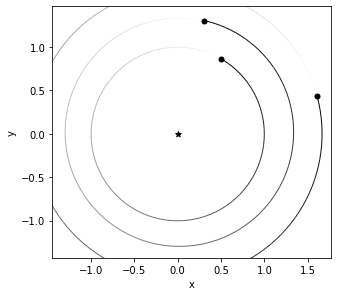

In [9]:
sim = rebound.Simulation('kep23-000140.bin')
m0, abar, m, a, ecross, ehill = calcarrays(sim)
rebound.OrbitPlot(sim)

In [12]:
from rebound import InterruptiblePool        
from spock import StabilityClassifier
from celmech import Andoyer

def init_process():
    global sc
    sc = StabilityClassifier()

pool = InterruptiblePool(processes=4, initializer=init_process)

In [21]:
%%time
params = [(i,m0,m,a,0.2) for i in range(1000)]
res = pool.map(run, params)

CPU times: user 62.4 ms, sys: 21.3 ms, total: 83.8 ms
Wall time: 1min 9s


In [22]:
import pandas as pd

df = pd.DataFrame(res, columns=['e1', 'e2', 'e3', 'Z12', 'Z23', 'ecom', 'T15stable', 'SPOCKstable'])
df.head()

,e1,e2,e3,Z12,Z23,ecom,T15stable,SPOCKstable
0,0.148164,0.147632,0.132301,0.166062,0.195947,0.041113,0,0.000000
1,0.129154,0.109970,0.086316,0.162812,0.080217,0.042047,0,0.000000
2,0.132060,0.131958,0.090476,0.176215,0.091170,0.048880,0,0.006253
3,0.148432,0.142944,0.070876,0.113497,0.123920,0.047934,0,0.000000
4,0.196675,0.169094,0.197613,0.117005,0.217125,0.074759,0,0.000000


In [31]:
df[df['T15stable'] > 0]

,e1,e2,e3,Z12,Z23,ecom,T15stable,SPOCKstable


(array([2.37142395, 3.59359882, 1.6519906 , 0.57680008, 0.90007149,
        0.68226969, 0.40043552, 0.72827286, 0.11862437, 0.02939883]),
 array([0.00343656, 0.03091465, 0.05839274, 0.08587082, 0.11334891,
        0.140827  , 0.16830509, 0.19578318, 0.22326126, 0.25073935,
        0.27821744]),
 <a list of 10 Patch objects>)

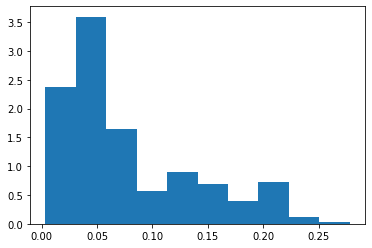

In [26]:
fig, ax = plt.subplots()
ax.hist(df['Z12'], weights=df['SPOCKstable'])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.00343656, 0.03091465, 0.05839274, 0.08587082, 0.11334891,
        0.140827  , 0.16830509, 0.19578318, 0.22326126, 0.25073935,
        0.27821744]),
 <a list of 10 Patch objects>)

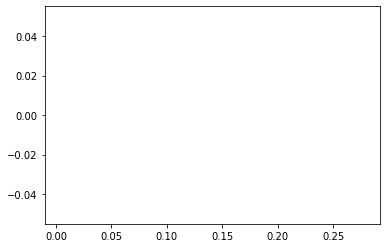

In [29]:
fig, ax = plt.subplots()
ax.hist(df['Z12'], weights=df['T15stable'])

(array([0.16498617, 0.49915198, 0.17854784, 1.72332603, 1.12618041,
        2.62607436, 1.38175139, 0.86940312, 0.83191662, 0.50275876,
        0.1792358 , 0.20238637, 0.18636674, 0.15324316, 0.16549206,
        0.09056861, 0.05470954, 0.03454908, 0.08223819, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.00147396, 0.00833797, 0.01520198, 0.02206598, 0.02892999,
        0.03579399, 0.042658  , 0.04952201, 0.05638601, 0.06325002,
        0.07011403, 0.07697803, 0.08384204, 0.09070605, 0.09757005,
        0.10443406, 0.11129806, 0.11816207, 0.12502608, 0.13189008,
        0.13875409, 0.1456181 , 0.1524821 , 0.15934611, 0.16621011,
        0.17307412, 0.17993813, 0.18680213, 0.19366614, 0.20053015,
        0.20739415, 0.21425816, 0.22112216, 0.

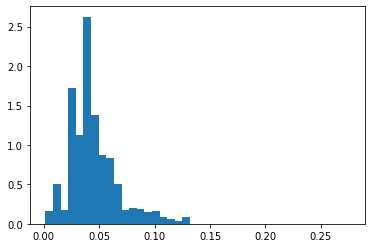

In [28]:
fig, ax = plt.subplots()
ax.hist(df['Z23'], weights=df['SPOCKstable'], bins=40)

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8d391ae610>)

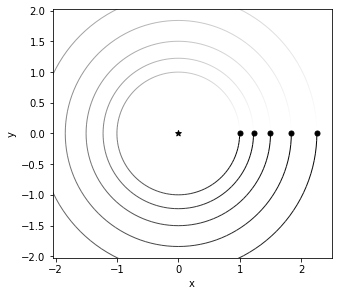

In [235]:
mp=1e-5
eH = (2*mp/3)**(1/3)
sim.add(m=mp, a=1)
Delta=12
Nplanets=5

basesim = rebound.Simulation()
basesim.add(m=1)
basesim.add(m=mp,a=1)
for i in range(Nplanets-1):
    basesim.add(m=mp, a=basesim.particles[-1].a*(1+Delta*eH))
rebound.OrbitPlot(basesim)

In [236]:
(basesim.particles[2].a-basesim.particles[1].a)/basesim.particles[1].a

0.22584864693144718

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8d3919e310>)

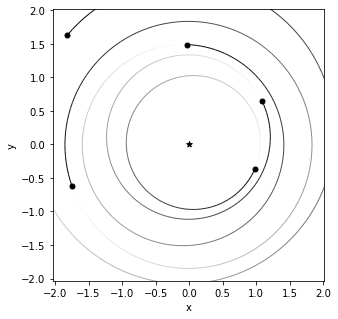

In [237]:
rebound.OrbitPlot(samplesim(basesim, emax=0.1))

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fba50f63ed0>)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


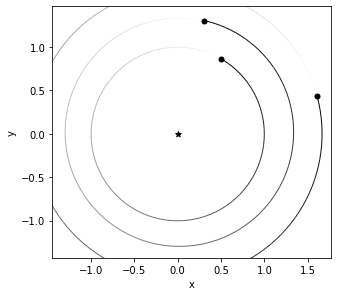

In [2]:
sim = rebound.Simulation('kep23-000140.bin')
m0, abar, m, a, ecross, ehill = calcarrays(basesim)
rebound.OrbitPlot(sim)

In [3]:
ps = sim.particles
ps[2].P/ps[1].P

1.5110668113273615

In [4]:
ps[3].P/ps[2].P

1.4221822502487445

In [313]:
m0, abar, m, a, ecross, ehill = calcarrays(basesim)

In [296]:
ecross

array([0.23867731, 0.26255267])

In [306]:
ehill

array([0.02030675, 0.02354222])

In [308]:
((basesim.particles[1].m+basesim.particles[2].m)/3)**(1/3)

0.02030675161350847

In [303]:
%%time
e = []
for i in range(10000):
    sim = samplesim(basesim, emax=0.15)
    if tremaine_stable(sim, Deltacrit=9):
        e.append(sim.particles[2].e)

CPU times: user 1.73 s, sys: 2.54 ms, total: 1.73 s
Wall time: 1.73 s


In [304]:
e

[0.009799809360782747]

(array([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.]),
 array([-0.49020019, -0.39020019, -0.29020019, -0.19020019, -0.09020019,
         0.00979981,  0.10979981,  0.20979981,  0.30979981,  0.40979981,
         0.50979981]),
 <a list of 10 Patch objects>)

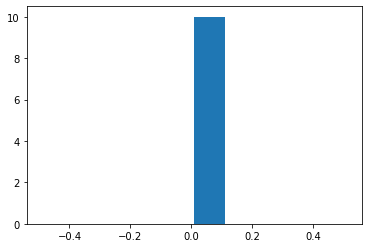

In [305]:
fig,ax = plt.subplots()
ax.hist(e, density=True)

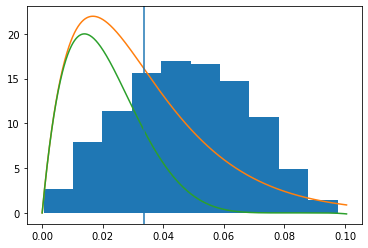

In [284]:
fig,ax = plt.subplots()
ax.hist(e, density=True)

tau = calc_tau(sim, Deltacrit=4)
es = np.linspace(0, 6*tau, 1000)
p = es/tau**2*np.exp(-es/tau)
p2 = es/tau**2*(1-es/tau/5)**5
ax.plot(es, p)
ax.plot(es, p2)
ax.axvline(2*tau)

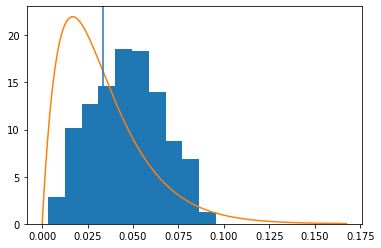

In [273]:
fig,ax = plt.subplots()
ax.hist(e, density=True)

tau = calc_tau(sim, Deltacrit=4)
es = np.linspace(0, 10*tau, 1000)
p = es/tau**2*np.exp(-es/tau)
ax.plot(es, p)
ax.axvline(2*tau)

# emax 0.12

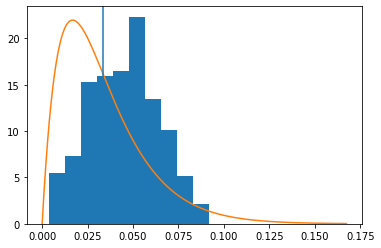

In [270]:
fig,ax = plt.subplots()
ax.hist(e, density=True)

tau = calc_tau(sim, Deltacrit=4)
es = np.linspace(0, 10*tau, 1000)
p = es/tau**2*np.exp(-es/tau)
ax.plot(es, p)
ax.axvline(2*tau)

(array([901., 843., 727., 718., 631., 551., 535., 520., 447., 409., 373.,
        348., 346., 294., 279., 215., 242., 224., 181., 167., 173., 128.,
        116., 121.,  88.,  77.,  64.,  48.,  43.,  46.,  34.,  30.,  18.,
         28.,  15.,   5.,   9.,   2.,   3.,   1.]),
 array([4.50328019e-06, 3.83434700e-03, 7.66419071e-03, 1.14940344e-02,
        1.53238781e-02, 1.91537219e-02, 2.29835656e-02, 2.68134093e-02,
        3.06432530e-02, 3.44730967e-02, 3.83029404e-02, 4.21327841e-02,
        4.59626279e-02, 4.97924716e-02, 5.36223153e-02, 5.74521590e-02,
        6.12820027e-02, 6.51118464e-02, 6.89416902e-02, 7.27715339e-02,
        7.66013776e-02, 8.04312213e-02, 8.42610650e-02, 8.80909087e-02,
        9.19207524e-02, 9.57505962e-02, 9.95804399e-02, 1.03410284e-01,
        1.07240127e-01, 1.11069971e-01, 1.14899815e-01, 1.18729658e-01,
        1.22559502e-01, 1.26389346e-01, 1.30219190e-01, 1.34049033e-01,
        1.37878877e-01, 1.41708721e-01, 1.45538564e-01, 1.49368408e-01,
      

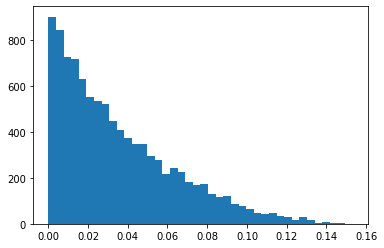

In [114]:
fig,ax = plt.subplots()
ax.hist(effe2s, bins=40)

(array([928., 790., 715., 705., 615., 534., 533., 491., 465., 427., 356.,
        344., 347., 295., 292., 258., 224., 206., 204., 163., 150., 136.,
        132., 115.,  94.,  80.,  65.,  70.,  54.,  45.,  40.,  33.,  27.,
         18.,  10.,  12.,  10.,   9.,   6.,   2.]),
 array([4.72518994e-06, 3.79997700e-03, 7.59522882e-03, 1.13904806e-02,
        1.51857324e-02, 1.89809843e-02, 2.27762361e-02, 2.65714879e-02,
        3.03667397e-02, 3.41619915e-02, 3.79572433e-02, 4.17524952e-02,
        4.55477470e-02, 4.93429988e-02, 5.31382506e-02, 5.69335024e-02,
        6.07287542e-02, 6.45240060e-02, 6.83192579e-02, 7.21145097e-02,
        7.59097615e-02, 7.97050133e-02, 8.35002651e-02, 8.72955169e-02,
        9.10907687e-02, 9.48860206e-02, 9.86812724e-02, 1.02476524e-01,
        1.06271776e-01, 1.10067028e-01, 1.13862280e-01, 1.17657531e-01,
        1.21452783e-01, 1.25248035e-01, 1.29043287e-01, 1.32838539e-01,
        1.36633791e-01, 1.40429042e-01, 1.44224294e-01, 1.48019546e-01,
      

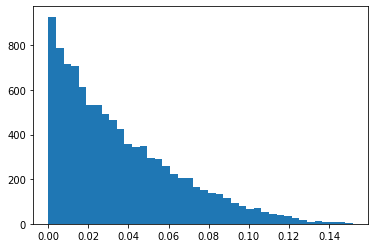

In [120]:
fig,ax = plt.subplots()
ax.hist(effe2s, bins=40)

In [40]:
sim = samplesim(emax=0.15)
tremaine_stable(sim)

0.09853735945368851


0

0.16651569762762325


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8d29903a10>)

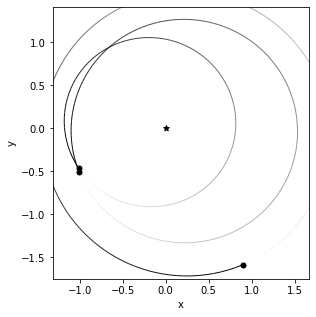

In [41]:
sim = samplesim(emax=0.2)
rebound.OrbitPlot(sim)

In [ ]:
# deprecated...tau only applies for when you marginalize over a's, not for fixed a's. Efficientsample doesn't work, need uniform in all 3

In [ ]:
def calc_tau(sim, Deltacrit=9):
    m0, abar, m, a, ecross, ehill = calcarrays(sim)
    Delta_a = (a[-1]-a[0])
    F = abar*Deltacrit/Delta_a*ehill.sum()
    return Delta_a*(1-F)/6/(sim.N-1)/abar
    
def efficientsamplesim(m0, abar, m, a, ecross, ehill, Deltacrit=9):
    e = np.zeros(len(a))
    
    sim = rebound.Simulation()
    sim.add(m=m0)
    
    for i in range(len(a)):
        if i==0:
            emax1 = 1
        else:
            emax1 = ecross[i-1]-Deltacrit*ehill[i-1]-e[i-1]
        if i==len(a)-1:
            emax2 = 1
        else:
            emax2 = ecross[i]-Deltacrit*ehill[i]
        
        emax = min(emax1,emax2)
        if emax < 0:
            raise AttributeError('emax for planet{0} < 0'.format(i))
        e[i] = np.sqrt(random()*emax**2)
        sim.add(m=m[i], a=a[i], e=e[i], pomega=random()*2*np.pi, M=random()*2*np.pi)

    sim.move_to_com()
    
    return sim